# Preparing a proposal

**<font color=red>Updated to use [pyvo pulled from GitHub](https://github.com/astropy/pyvo) on 2019-07-08.  Notes in red about issues or features we can/should add to pyvo from our navo_utils.</font>**

The Story: Suppose that you are preparing to write a proposal on NGC1365, aiming to investigate the intriguing black hole spin this galaxy with Chandra grating observations (see: https://www.space.com/19980-monster-black-hole-spin-discovery.html ) 

In writing proposals, there are often the same tasks that are required: including finding and analyzing previous observations of the proposal, and creating figures that include, e.g., multiwavelength images and spectrum for the source. 


In [1]:
##
##  For DEBUGGING
## 
%load_ext autoreload
%autoreload 2

# As a hint, we include the code block for Python modules that you will likely need to import:   
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  

##  Use pyvo as much as possible
import pyvo as vo


## There are a number of relatively unimportant warnings that 
## show up, so for now, suppress them:
import warnings
warnings.filterwarnings("ignore")


### Step 1: Find out what the previously quoted Chandra 2-10 keV flux of the central source is for NGC 1365.  

Hint: Do a table access protocol (TAP) search in the heasarc, to find potential table with this information

<font color=red>No "source" but "keywords" is fine for the same thing.  
    
Then you can take the set of results and browse them as a table with 

    tap_services.table
    
or you can take one of them and use it as a service with

    tap_services[0].search(query)

(Is there another way to get the URL as a string?  The getdataurl() doesn't work with this object.  I guess the idea is that you shouldn't *need* to see the URL.)  
</font>
    

In [2]:
#tap_services=Registry.query(service_type='table',source='heasarc')
tap_services=vo.regsearch(servicetype='table',keywords=['heasarc'])
url=tap_services[0]['access_url'].decode("utf-8")
print(url)

https://heasarc.gsfc.nasa.gov/xamin/vo/tap


Hint: The Chansngcat ( https://heasarc.gsfc.nasa.gov/W3Browse/chandra/chansngcat.html ) table is likely the best table.  Create a table with ra, dec, exposure time, and flux (and flux errors) from the public.chansngcat catalog for Chandra observations matched within 0.1 degree.

In [3]:
print("Found {} services:".format(len(tap_services)))
for s in tap_services:
    print(s.res_description)

Found 1 services:
The HEASARC is NASA domain archive for high-energy and microwave astronomy.
     The Xamin interface provides access to over 600 observation and object
     tables.  This includes observation tables for more than 30 missions
     and observatories and hundreds of derived object tables.
     Non-high energy tables are included to make it easier
     for users to compare information.


<font color=red>
I think we should be learning/teaching how to chain pyvo objects themselves.  For example, ** 

    tap_services[0]
    
is a row of the registry results, and if you tack on .service, it becomes the appropriate service type object (e.g., a TAPService or an SIAService).  But you don't necessarily have to, because special functions work on the registry result row itself.  These two are equivalent I think:

    tap_services[0].service.run_sync(query)
    tap_services[0].search(query)
    
for example for a TAP service, or 

    image_services[0].search(position,size)

for an image.

One annoying exception that I think should be "exposed" higher is that for a TAP services, if you want to find the available tables, then that's the .tables object, but this doesn't work on a row of a result set;  you have to specify the .service attribute first:

    tap_services[0].service.tables
    
(not to be confused with .table, which converts the results into an Astropy Table object) which returns an VOSITables object that can work like a dictionary whose keys are the table names and values are tables of its meta data.  So you can do the following, or at least should be able to when it's made to work(?):
</font>

In [9]:
heasarc_tables=tap_services[0].service.tables
for tablename in heasarc_tables.keys():
    if "chan" in tablename:  
        print(tablename)
        print(heasarc_tables[tablename].description)
        ## These don't appear to work
        #heasarc_tables[tablename].describe()
        #print(heasarc_tables[tablename].columns)
        

bmwchancat
None
chandfn1ms
None
chandfn2ms
None
chandfs1ms
None
chandfs2ms
None
chandfs4ms
None
chandfs7ms
None
chanextdfs
None
changbscat
None
chanmaster
None
channsgpsc
None
chansexagn
None
chansexoid
None
chansexsi
None
chansngcat
None
chantypgpr
None
chanulxcat
None
chanvguide
None


<font color=red>  But is this starting to be a bit annoying for the average user, making sure to use the right methods to get the right kinds of objects called in the right ways?  I've figured this out reading the code and lots of trial and error.  The docs don't cover this quite the way I needed.</font>

In [10]:
# Get the coordinate for NGC 1365
import astropy.coordinates as coord
pos=coord.SkyCoord.from_name("ngc1365")
query="""SELECT ra, dec, exposure, flux, flux_lower, flux_upper 
    FROM public.chansngcat as cat 
    where 
    contains(point('ICRS',cat.ra,cat.dec),circle('ICRS',{},{},0.1))=1 
    and 
    cat.exposure > 0 order by cat.exposure
    """.format(pos.ra.deg, pos.dec.deg)


In [11]:
## Show the results from your table query for NGC 1365 
#results=tap_services[0].service.run_sync(query)
results=tap_services[0].search(query)
results.table

ra,dec,exposure,flux,flux_lower,flux_upper
float64,float64,float64,float64,float64,float64
53.40191667,-36.14066667,15500.0,7.751e-12,7.1727e-12,8.2075e-12



### Step 2: Make Images: 

#### Create ultraviolet and X-ray images
Hint: Start by checking what UV image services exist (e.g., GALEX?)

<font color=red>
As above, add .table to browse the results more easily.
</font>

In [12]:
## Note that to browse more 'prettily', use the .table attribute
uv_services=vo.regsearch(servicetype='image',keywords='galex', waveband='uv')
## Can't do two columns at a time with this way:
uv_services.table['ivoid','short_name']


ivoid,short_name
object,object
ivo://archive.stsci.edu/sia/galex,GALEX
ivo://mast.stsci/siap/galex_atlas,GALEX_Atlas
ivo://mast.stsci/siap/hst.maoz_atlas,HST.maoz_atlas
ivo://mast.stsci/siap/udfuv,HST.udfuv
ivo://mast.stsci/siap/uit,UIT
ivo://nasa.heasarc/skyview/euve,EUVE
ivo://nasa.heasarc/skyview/galex,GALEX
ivo://nasa.heasarc/skyview/wfcf,WFCF


Here's how you select the services you're interested in.  Take the table of results

    uv_services.table

and search the relevant column for the relevant string

    np.isin(uv_services.table['short_name'],b'GALEX')

and use the resulting indices of where the GALEX entries are to look at three of the table columns for only those GALEX rows:

    uv_services.table[
        np.isin(uv_services.table['short_name'],b'GALEX')
        ]['ivoid','short_name','access_url']


There are two that serve GALEX images:

In [13]:
uv_services.table[
    np.isin(uv_services.table['short_name'],b'GALEX')
    ]['ivoid','short_name','access_url']

ivoid,short_name,access_url
object,object,object
ivo://archive.stsci.edu/sia/galex,GALEX,https://mast.stsci.edu/portal/Mashup/VoQuery.asmx/SiaV1?MISSION=GALEX&
ivo://nasa.heasarc/skyview/galex,GALEX,https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl?survey=galex&


<font color=red>But the above uses and returns a table which you cannot call.  So you want to get the elements of the original object that are callable.

But slicing the object as though it's a table doesn't work, i.e., these don't work:

    services[0:1]
    services[ np.where(np.isin(services.table['short_name'],b'GALEX'))[0] ]

</font>

In [14]:
## The where returns a tuple, but we only want the first part of the tuple, the array of indices.
##  But you cannot pass more than one integer to a results object to get something callable, i.e.
##  though some table operations work, it doesn't slice like a table.  So get them separately by
##  specifying the first and second of the two matches from the where:
galex_stsci=uv_services[int(np.where(np.isin(uv_services.table['short_name'],b'GALEX'))[0][0])]
galex_heasarc=uv_services[int(np.where(np.isin(uv_services.table['short_name'],b'GALEX'))[0][1])]

**<font color=red>But this is overly ugly.  Took me lots of trial and error and reading code to figure out how exactly to get what I want out of the pyvo objects.  And given that the results may be returned in a different order tomorrow, we cannot just hard-wire the numbers.  There's got to be a better way to do this.</font>**

<font color=red>  This is how we did it with the navo_utils:

    uv_services=Registry.query(service_type='image',keyword='galex', waveband='uv')
    im_gal = uv_services[np.isin(uv_services['short_name'], 
                                        ['GALEX'])]
    
Since everything was just tables, they could be sliced and diced.  But then you cannot do the below way of just tacking on .search() to the result entry, which is handy.
</font>

Hint: Next create a UV image for the source 

In [15]:
# Do an image search for NGC 1365 in the UV service found above
im_table_stsci=galex_stsci.search(pos=pos,size=0.1)
im_table_stsci.table

collection,insName,name,posLocationRA,posLocationDec,contentLength,naxes,naxis,scale,contentType,coordFrame,projection,crpix,crval,cdmatrix,enrEMBand,enrUnits,enrValue,enrMax,enrMin,accessURL
object,object,object,float64,float64,int32,int32,object,object,object,object,bytes3,object,object,object,object,object,float64,float64,float64,object
GALEX,GALEX,fornax_mos06-xd-int_2color_medium_annot.jpg,53.0653359237686,-36.3609134371405,543324,2,[3840 3840],[0.000416667 0.000416667],image/jpeg,ICRS,TAN,[1920.5 1920.5],[158.369 3.98986],[-0.000416667 -0.0 -0.0 0.000416667],UV,meters,2.35e-07,3.007e-07,1.693e-07,http://galex.stsci.edu/data/GR6/pipe/01-vsn/07090-FORNAX_MOS06/d/01-main/0001-img/07-try/qa/FORNAX_MOS06-xd-int_2color_medium_annot.jpg
GALEX,GALEX,fornax_mos06-nd-int.fits.gz,53.0653359237686,-36.3609134371405,17443052,2,[3840 3840],[0.000416667 0.000416667],image/fits,ICRS,TAN,[1920.5 1920.5],[158.369 3.98986],[-0.000416667 -0.0 -0.0 0.000416667],UV,meters,2.35e-07,3.007e-07,1.693e-07,http://galex.stsci.edu/data/GR6/pipe/01-vsn/07090-FORNAX_MOS06/d/01-main/0001-img/07-try/FORNAX_MOS06-nd-int.fits.gz
GALEX,GALEX,fornax_mos06-xd-int_2color.jpg,53.0653359237686,-36.3609134371405,1799018,2,[3840 3840],[0.000416667 0.000416667],image/jpeg,ICRS,TAN,[1920.5 1920.5],[273.981 16.9244],[-0.000416667 -0.0 -0.0 0.000416667],UV,meters,2.35e-07,3.007e-07,1.693e-07,http://galex.stsci.edu/data/GR6/pipe/01-vsn/07090-FORNAX_MOS06/d/01-main/0001-img/07-try/qa/FORNAX_MOS06-xd-int_2color.jpg
GALEX,GALEX,fornax_mos06-xd-int_2color_large.jpg,53.0653359237686,-36.3609134371405,347009,2,[3840 3840],[0.000416667 0.000416667],image/jpeg,ICRS,TAN,[1920.5 1920.5],[273.981 16.9244],[-0.000416667 -0.0 -0.0 0.000416667],UV,meters,2.35e-07,3.007e-07,1.693e-07,http://galex.stsci.edu/data/GR6/pipe/01-vsn/07090-FORNAX_MOS06/d/01-main/0001-img/07-try/qa/FORNAX_MOS06-xd-int_2color_large.jpg
GALEX,GALEX,fornax_mos06-xd-int_2color_medium.jpg,53.0653359237686,-36.3609134371405,460391,2,[3840 3840],[0.000416667 0.000416667],image/jpeg,ICRS,TAN,[1920.5 1920.5],[273.981 16.9244],[-0.000416667 -0.0 -0.0 0.000416667],UV,meters,2.35e-07,3.007e-07,1.693e-07,http://galex.stsci.edu/data/GR6/pipe/01-vsn/07090-FORNAX_MOS06/d/01-main/0001-img/07-try/qa/FORNAX_MOS06-xd-int_2color_medium.jpg
GALEX,GALEX,fornax_mos06-xd-int_2color_small.jpg,53.0653359237686,-36.3609134371405,122927,2,[3840 3840],[0.000416667 0.000416667],image/jpeg,ICRS,TAN,[1920.5 1920.5],[273.981 16.9244],[-0.000416667 -0.0 -0.0 0.000416667],UV,meters,2.35e-07,3.007e-07,1.693e-07,http://galex.stsci.edu/data/GR6/pipe/01-vsn/07090-FORNAX_MOS06/d/01-main/0001-img/07-try/qa/FORNAX_MOS06-xd-int_2color_small.jpg
GALEX,GALEX,fornax_mos07-xd-int_2color_medium_annot.jpg,54.0331936068986,-36.367881838288,606044,2,[3840 3840],[0.000416667 0.000416667],image/jpeg,ICRS,TAN,[1920.5 1920.5],[48.4385 0.19652],[-0.000416667 -0.0 -0.0 0.000416667],UV,meters,2.35e-07,3.007e-07,1.693e-07,http://galex.stsci.edu/data/GR6/pipe/01-vsn/07091-FORNAX_MOS07/d/01-main/0001-img/07-try/qa/FORNAX_MOS07-xd-int_2color_medium_annot.jpg
GALEX,GALEX,fornax_mos07-nd-int.fits.gz,54.0331936068986,-36.367881838288,21333361,2,[3840 3840],[0.000416667 0.000416667],image/fits,ICRS,TAN,[1920.5 1920.5],[48.4385 0.19652],[-0.000416667 -0.0 -0.0 0.000416667],UV,meters,2.35e-07,3.007e-07,1.693e-07,http://galex.stsci.edu/data/GR6/pipe/01-vsn/07091-FORNAX_MOS07/d/01-main/0001-img/07-try/FORNAX_MOS07-nd-int.fits.gz
GALEX,GALEX,fornax_mos07-xd-int_2color.jpg,54.0331936068986,-36.367881838288,2275679,2,[3840 3840],[0.000416667 0.000416667],image/jpeg,ICRS,TAN,[1920.5 1920.5],[357.46 -9.93379],[-0.000416667 -0.0 -0.0 0.000416667],UV,meters,2.35e-07,3.007e-07,1.693e-07,http://galex.stsci.edu/data/GR6/pipe/01-vsn/07091-FORNAX_MOS07/d/01-main/0001-img/07-try/qa/FORNAX_MOS07-xd-int_2color.jpg


In [16]:
# Do an image search for NGC 1365 in the UV service found above
im_table_heasarc=galex_heasarc.search(pos=pos,size=0.2)
im_table_heasarc.table

Survey,Ra,Dec,Dim,Size,Scale,Format,PixFlags,URL,LogicalName
object,float64,float64,int32,object,object,object,object,object,object
galexnear,53.40190833,-36.14065833,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=53.40190833%2C-36.14065833&survey=galexnear&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1562959962113&return=FITS,1
galexnear,53.40190833,-36.14065833,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/tiff,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=53.40190833%2C-36.14065833&survey=galexnear&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1562959962113&nofits=1&quicklook=tiff&return=tiff,1
galexnear,53.40190833,-36.14065833,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/gif,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=53.40190833%2C-36.14065833&survey=galexnear&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1562959962113&nofits=1&quicklook=gif&return=gif,1
galexnear,53.40190833,-36.14065833,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/png,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=53.40190833%2C-36.14065833&survey=galexnear&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1562959962113&nofits=1&quicklook=png&return=png,1
galexnear,53.40190833,-36.14065833,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/jpeg,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=53.40190833%2C-36.14065833&survey=galexnear&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1562959962113&nofits=1&quicklook=jpeg&return=jpeg,1
galexfar,53.40190833,-36.14065833,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=53.40190833%2C-36.14065833&survey=galexfar&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1562959963039&return=FITS,2
galexfar,53.40190833,-36.14065833,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/tiff,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=53.40190833%2C-36.14065833&survey=galexfar&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1562959963039&nofits=1&quicklook=tiff&return=tiff,2
galexfar,53.40190833,-36.14065833,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/gif,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=53.40190833%2C-36.14065833&survey=galexfar&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1562959963039&nofits=1&quicklook=gif&return=gif,2
galexfar,53.40190833,-36.14065833,2,[300 300],[-0.0006666666666666668 0.0006666666666666668],image/png,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=53.40190833%2C-36.14065833&survey=galexfar&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1562959963039&nofits=1&quicklook=png&return=png,2


**<font color=red>Note that our navo_utils.Image.query() takes a position and RADIUS.  This takes a position and a SIZE, which is apparently a diameter.  So there's a factor of two difference in what you give.  Is this what people will expect from an SIA interface?</font>**

In [17]:
## Get the FITS file, first of above rows.  

##  There are a couple of things you can extract 
##   from each row of the results:


## Shouldn't need this
print(im_table_heasarc[0].getdataurl())  
## For downloading the file, see below
dataset=im_table_heasarc[0].getdataset() 
## For grabbing the FITS as an astropy.io.fits object in memory
dataobj=im_table_heasarc[0].getdataobj()

https://skyview.gsfc.nasa.gov/cgi-bin/images?position=53.40190833%2C-36.14065833&survey=galexnear&pixels=300%2C300&sampler=LI&size=0.20000000000000004%2C0.20000000000000004&projection=Tan&coordinates=J2000.0&requestID=skv1562959962113&return=FITS


In [18]:
print(type(dataset)) 
print(type(dataobj))

<class 'urllib3.response.HTTPResponse'>
<class 'astropy.io.fits.hdu.hdulist.HDUList'>


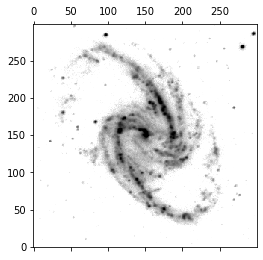

In [19]:
# make an image: 
from pylab import figure, cm
from matplotlib.colors import LogNorm
plt.matshow(dataobj[0].data, origin='lower', cmap=cm.gray_r, norm=LogNorm(vmin=0.005, vmax=0.3))

**<font color=red>Note that each record has a lot of information in it.  Need a method to print this information in a useful way, which I don't currently see.  Doesn't have, e.g., a .table attribute.</font>**

**<font color=red>The change in the column names (e.g., "Format" versus "content-Type" versus "imgfmt" etc.) is presumably why there's a getdataformat() function.  Not sure I like this, though.  Can see how it relates to our navo_utils UCD conversion stuff.</font>**

In [20]:
print(type(im_table_heasarc[0]))
print(im_table_heasarc[0].getdataformat())
dir(im_table_heasarc[0])

<class 'pyvo.dal.sia.SIARecord'>
image/fits


['__abstractmethods__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_dsname_no',
 '_get_soda_resource',
 '_index',
 '_mapping',
 '_results',
 'acref',
 'acref_ttl',
 'bandpass_hilimit',
 'bandpass_id',
 'bandpass_lolimit',
 'bandpass_refvalue',
 'bandpass_unit',
 'broadcast_samp',
 'cachedataset',
 'cdmatrix',
 'coord_equinox',
 'coord_frame',
 'coord_projection',
 'coord_refpixel',
 'coord_refvalue',
 'dateobs',
 'filesize',
 'format',
 'get',
 'getbyucd',
 'getbyutype',
 'getdataformat',

Hint: Repeat steps for X-ray image. (Note: Ideally, we would find an image in the Chandra 'cxc' catalog) 

In [21]:
x_services=vo.regsearch(servicetype='image',keywords=['chandra'], waveband='x-ray')
print(x_services.table['short_name','ivoid'])

 short_name                 ivoid                 
----------- --------------------------------------
        CDA         ivo://cxc.harvard.edu/cda.siap
        CSC         ivo://cxc.harvard.edu/csc.siap
    Chandra          ivo://nasa.heasarc/chanmaster
GOODSACISFB ivo://nasa.heasarc/skyview/goodsacisfb


In [22]:
## Do an image search for NGC 1365 in the X-ray CDA service found above
xim_table=x_services[0].search(pos=pos,size=0.2)
## Some of these are FITS and some JPEG.  Look at the columns:
print( xim_table.table.columns )
first_fits_image_row=xim_table[ int(np.where(np.isin(xim_table.table['imgfmt'],b'image/fits'))[0][0]) ] 

<TableColumns names=('name','instrument','date_obs','ra','dec','naxis','imgscale','imgfmt','accref','filesize','obsid')>


(460, 560)

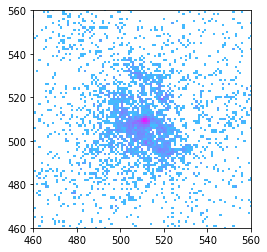

In [23]:
# Create an image from the first FITS file (index=1) by downloading:
xhdu_list=first_fits_image_row.getdataobj()

plt.imshow(xhdu_list[0].data, origin='lower', cmap='cool', norm=LogNorm(vmin=0.1, vmax=500.))
plt.xlim(460, 560)
plt.ylim(460, 560)


### Step 3: Make a spectrum: 

#### Find what Chandra spectral observations exist already for this source. 
Hint: try searching for X-ray spectral data tables using the registry query

**<font color=red>Why do these two ways of asking for spectral access services return different results?  Looks like it's doing an exact rather than partial match, so services that are "x-ray#gamma-ray" don't get found by pyvo.  Didn't help to try waveband='%x-ray%', but there ought to be a way.</font>**

In [24]:
# Use the TAP protocol to list services that contain X-ray spectral data
xsp_services=vo.regsearch(servicetype='ssa',waveband='x-ray')
xsp_services.table['short_name','ivoid','waveband']


short_name,ivoid,waveband
object,object,object
Chandra,ivo://nasa.heasarc/chanmaster,x-ray


<font color=red>This is the way our navo_utils.registry did it and what it finds:</font>

In [25]:
from navo_utils.registry import Registry
services=Registry.query(service_type='spectr',waveband='x-ray')
services['short_name','ivoid','waveband']

short_name,ivoid,waveband
str14,str49,str56
HEAVENS @ ISDC,ivo://wfau.roe.ac.uk/heavens_at_isdc/light-curves,x-ray#gamma-ray
NED/SED,ivo://ned.ipac/sed_data_near_position,radio#millimeter#infrared#optical#uv#euv#x-ray#gamma-ray
Chandra,ivo://nasa.heasarc/chanmaster,x-ray
INTEGRAL/BSC,ivo://nasa.heasarc/intbsc,gamma-ray#x-ray


Hint 2: Take a look at what data exist for our candidate, NGC 1365.

**<font color=red>I'd also request that "service unavailable" and a few other errors be trapped for and a simple message printed rather than the whole traceback from an exception</font>

In [30]:
spec_tables=xsp_services[0].search(pos=pos,radius=0.2,verbose=True)
spec_tables.table

obsid,status,name,ra,dec,time,detector,grating,exposure,type,pi,public_date,SSA_start_time,SSA_tmid,SSA_stop_time,SSA_duration,SSA_coord_obs,SSA_ra,SSA_dec,SSA_title,SSA_reference,SSA_datalength,SSA_datamodel,SSA_instrument,SSA_publisher,SSA_format,SSA_fov,SSA_wavelength_min,SSA_wavelength_max,SSA_bandwidth,SSA_bandpass
,,,deg,deg,mjd,,,s,,,mjd,mjd,mjd,mjd,s,deg,deg,deg,,,,,,,,deg,meter,meter,meter,meter
object,object,object,float64,float64,float64,object,object,float64,object,object,int32,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,float64,float64,float64,float64,float64
13920,archived,NGC 1365,53.40167,-36.14028,56026.4065,ACIS-S,HETG,90040,GO,Reeves,56398,56026.4065162037,56026.94252101314,56027.47776322905,90040.0,--,53.40167,-36.14028,acisf13920N001_pha2,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao13/cat7/13920/primary/acisf13920N001_pha2.fits.gz,12.0,Spectrum-1.0,ACIS-S,HEASARC,application/fits,0.81,1.2398e-10,6.1992e-09,6.07522e-09,3.16159e-09
13921,archived,NGC 1365,53.40167,-36.14028,56029.0272,ACIS-S,HETG,110050,GO,Reeves,56398,56029.0271643518,56029.68170909219,56030.335490666206,110050.0,--,53.40167,-36.14028,acisf13921N001_pha2,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao13/cat7/13921/primary/acisf13921N001_pha2.fits.gz,12.0,Spectrum-1.0,ACIS-S,HEASARC,application/fits,0.81,1.2398e-10,6.1992e-09,6.07522e-09,3.16159e-09


Hint 3: Download the data to make a spectrum. Note: you might end here and use Xspec to plot and model the spectrum. Or ... you can also try to take a quick look at the spectrum. 

**<font color=red>This ends up with a file named "acisf13920N001_pha2.None" instead of the correct ".fits" suffix.</font>**

In [31]:
## Or write it to disk
with open('downloads/{}'.format(spec_tables[0].make_dataset_filename()),'wb') as outfile:
    outfile.write(spec_tables[0].getdataset().read())

In [32]:
hdu_list=spec_tables[0].getdataobj()
spectra=hdu_list[1].data
print(spectra.columns)
print(len(spectra))

ColDefs(
    name = 'SPEC_NUM'; format = '1I'; null = 0
    name = 'TG_M'; format = '1I'; null = 99
    name = 'TG_PART'; format = '1I'
    name = 'TG_SRCID'; format = '1I'; null = 0
    name = 'X'; format = '1E'; unit = 'pixel'
    name = 'Y'; format = '1E'; unit = 'pixel'
    name = 'CHANNEL'; format = '8192I'; null = 0
    name = 'COUNTS'; format = '8192I'; unit = 'count'; null = -1
    name = 'STAT_ERR'; format = '8192E'; unit = 'count'
    name = 'BACKGROUND_UP'; format = '8192I'; unit = 'count'; null = -1
    name = 'BACKGROUND_DOWN'; format = '8192I'; unit = 'count'; null = -1
    name = 'BIN_LO'; format = '8192D'; unit = 'angstrom'
    name = 'BIN_HI'; format = '8192D'; unit = 'angstrom'
)
12


Extension: Making a "quick look" spectrum. For our purposes, the 1st order of the HEG grating data would be sufficient.

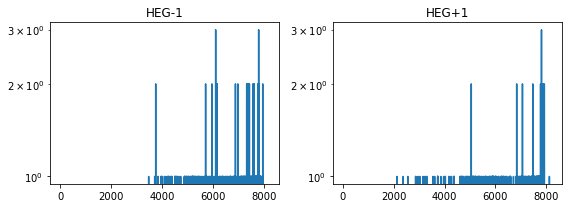

In [33]:
j=1
for i in range(len(spectra)):
    matplotlib.rcParams['figure.figsize'] = (8, 3)
    if abs(spectra['TG_M'][i]) == 1 and (spectra['TG_PART'][i]) == 1:
        ax=plt.subplot(1,2,j)
        pha = plt.plot( spectra['CHANNEL'][i],spectra['COUNTS'][i])
        ax.set_yscale('log')
        if spectra['TG_PART'][i] == 1:
            instr='HEG'
        ax.set_title("{grating}{order:+d}".format(grating=instr, order=spectra['TG_M'][i]))
        plt.tight_layout()
        j=j+1


This can then be analyzed in your favorite spectral analysis tool, e.g., [pyXspec](https://heasarc.gsfc.nasa.gov/xanadu/xspec/python/html/index.html).  (For the winter 2018 AAS workshop, we demonstrated this in a [notebook](https://github.com/NASA-NAVO/aas_workshop_2018/blob/master/heasarc/heasarc_Spectral_Access.ipynb) that you can consult for how to use pyXspec, but the pyXspec documentation will have more information.) 

Congratulations! You have completed this notebook exercise.